In [ ]:
# To avoid the error while plotting "AttributeError: 'GeoAxes' object has no attribute '_autoscaleXon'"
!pip install --user matplotlib==3.5.2

In [357]:
import numpy as np
import matplotlib.pyplot as plt

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from osgeo import gdal

from nansat import Nansat, Domain, NSR

from sea_ice_drift.lib import get_spatial_mean, get_uint8_image
from sea_ice_drift.ftlib import feature_tracking
from sea_ice_drift.pmlib import pattern_matching
from sea_ice_drift.libdefor import get_deformation_nodes

import xarray as xr

from matplotlib.patches import Rectangle

%matplotlib inline

In [ ]:
# Download arrays

f1 = gdal.Open(r'/home/jovyan/data/SAR_images/subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif')
f2 = gdal.Open(r'/home/jovyan/data/SAR_images/subset_of_S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV.tif')
f3 = gdal.Open(r'/home/jovyan/data/SAR_images_forecast/Forecasted_20221119T08_subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif')

In [ ]:
#Load the data from the files into numpy arrays for further processing.
a1 = f1.ReadAsArray() 
a2 = f2.ReadAsArray()
a3 = f3.ReadAsArray()

#Pre-process images to ensure consistent visualization and handle blank spots issue after pattern patching.

a1 = get_uint8_image(a1, None, None, 1, 99)
a2 = get_uint8_image(a2, None, None, 1, 99)
a3 = get_uint8_image(a3, None, None, 1, 99)

In [ ]:
#Plot
fig, ax = plt.subplots(1,3, figsize=(18,5))
im1 = ax[0].imshow(a1, clim=[0, 255])
ax[0].axis('off')
#plt.colorbar(im0, ax=ax[0])
im2 = ax[1].imshow(a2, clim=[0, 255])
ax[1].axis('off')
#plt.colorbar(im1, ax=ax[1])
im3 = ax[2].imshow(a3, clim=[0, 255])
ax[2].axis('off')
cax = fig.add_axes([0.92, 0.13, 0.02, 0.75])  # Position and size of the colorbar
cbar = fig.colorbar(im3, cax=cax)
#plt.colorbar(im3, ax=ax[2])

ax[0].set_title("SAR1 - 20221119")
ax[1].set_title("SAR2 - 20221120")
ax[2].set_title("SAR2 Forecasted 20221120")

plt.show()

In [ ]:
# Create three Nansat objects with original tiff georeference imported from gdal object.

srs_tiff = f1.GetSpatialRef() 

rows, cols = a1.shape
d_sar = Domain(srs_tiff, ds=f1)
n1 = Nansat.from_domain(d_sar, a1)
n2 = Nansat.from_domain(d_sar, a2)
n3 = Nansat.from_domain(d_sar, a3)

In [ ]:
# Close the dataset
f1 = None
f2 = None
f3 = None

In [ ]:
# Run Feature Tracking between SAR1 and SAR2 
# get start/end coordinates in the image coordinate system (colums/rows)  
c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=20000, ratio_test=0.6, max_drift=100000, verbose=True)

In [ ]:
# Plot identified and matched keypoints in geographic coordinates for SAR1 and SAR2 

# convert row/column coordinates of matched features to lon/lat
lon1ft, lat1ft = n1.transform_points(c1, r1)
lon2ft, lat2ft = n2.transform_points(c2, r2)

# get lon/lat coordinates of the border of images
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.Mercator())
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())

ax.legend()
plt.show()

In [ ]:
# Plot ice drift on top of image_1 for SAR1 and SAR2 

# end points in image_1 coordinate system
n1c2, n1r2 = n1.transform_points(lon2ft, lat2ft, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr = n1r2 - r1
dc = n1c2 - c1

# border of image_2 in image_1 coordinate system
n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(7,7))
plt.imshow(n1[1], cmap='gray')
plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=0.5)
plt.plot(n1lon2b, n1lat2b, 'k.-')
plt.show()

In [260]:
# Open the remote dataset with model data
data = xr.open_dataset("https://thredds.met.no/thredds/dodsC/fou-hi/barents_eps_eps/barents_eps_20221119T06Z.nc")

# Extract X and Y coordinates, as well as longitude and latitude values from the dataset
X = data['X']
Y = data['Y']
lon = data['lon']
lat = data['lat']

# Retrieve the proj4 string defining the Lambert Conformal projection of the dataset
proj4 = data.projection_lambert.proj4
print(proj4)

# Convert the proj4 string to a Nansat spatial reference object
srs = NSR(proj4)


#Get bound in rows and columns correspoding to the image borders set above
r,c = np.where((lon.data > min(lon1b))*(lon.data <  max(lon1b))*(lat.data >  min(lat1b))*(lat.data < max(lat1b)))
               
min(r), max(r), min(c), max(c)

+proj=lcc +lat_0=77.5 +lon_0=-25 +lat_1=77.5 +lat_2=77.5 +no_defs +R=6.371e+06


(460, 613, 2, 161)

In [ ]:
# Extract the subset grif out of the model grid based on the image bounds
#That grid and srs will be used for pattern matching ensuring the drift output aligns easily with the model data.
X_subset = X[min(c):max(c)+1]
Y_subset = Y[min(r):max(r)+1]
lon_subset = lon[min(r):max(r)+1, min(c):max(c)+1]
lat_subset = lat[min(r):max(r)+1, min(c):max(c)+1]


# Prepare coordinates for patern matching input
lon1pm = lon_subset.data
lat1pm = lat_subset.data

# Set up coordinates in meters for visualizing the pattern matching results.
x1pm, y1pm = np.meshgrid(X_subset, Y_subset)

In [ ]:
X_subset.shape, Y_subset.shape, r.shape, c.shape, lon_subset.shape, lon_subset.shape

In [ ]:
#Store variables to use in model_drift_export for subset
%store r
%store c
%store X_subset
%store Y_subset
%store lat_subset
%store lon_subset

In [ ]:
# Plot coverage of the first SAR1 image and subset grid imported from the model
# Top border
plt.plot(lon_subset[0, :], lat_subset[0, :], 'b-', label='Subset Grid Border')
# Bottom border
plt.plot(lon_subset[-1, :], lat_subset[-1, :], 'b-')
# Left border
plt.plot(lon_subset[:, 0], lat_subset[:, 0], 'b-')
# Right border
plt.plot(lon_subset[:, -1], lat_subset[:, -1], 'b-')

plt.plot(*n1.get_border(), '.-', label='First S1 image', c = 'red')
#plt.plot(*dom_pm.get_border(), '.-', label='ROI')
plt.legend()
plt.show()

In [ ]:
# Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Mercator (faked) projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2, angles=[-12,-10,-7,-5,-3,0,3,5,7, 10,12],
                                                          srs=srs.ExportToProj4())

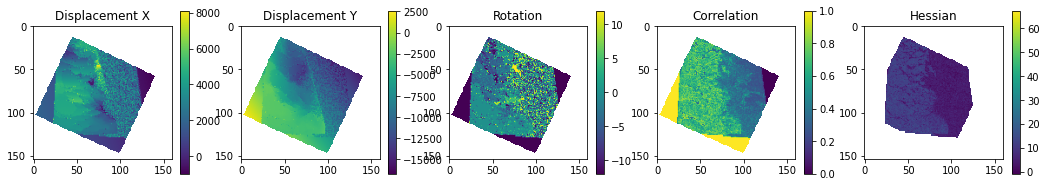

In [302]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))

for i, a in enumerate([upm, vpm, apm, rpm, hpm]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a) 
    plt.colorbar(im, ax=ax[i])


plt.show()

### Plotting the final results with SAR image

In [ ]:
# model domain to reproject SAR image from 3996
model_d = Domain(srs, f'-te {min(X_subset.data)} {min(Y_subset.data)} {max(X_subset.data)} {max(Y_subset.data)} -tr 100 100')

n1.reproject(model_d)

Number of True values in gpi: 4795


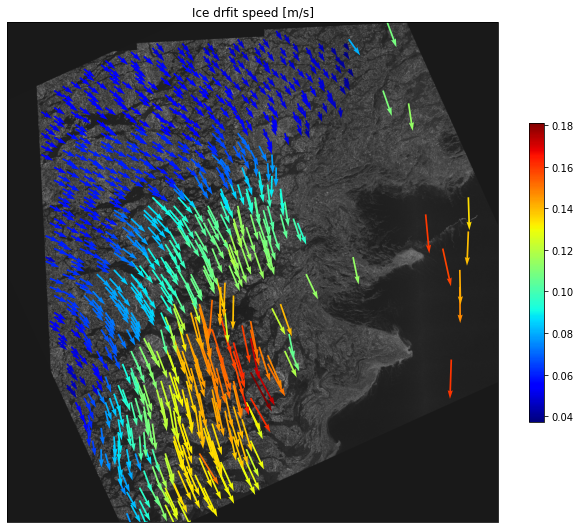

In [321]:
from matplotlib.patches import Rectangle

dayssec = 24*60*60 # !!!! provide real time difference time_period[-1]-time_period[0]

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 

# plot valid vectors in Polar stereographic projection
gpi = (hpm > 7)#*(siconc_subset > 0.92)
num_true_values = np.sum(gpi.data)
print(f"Number of True values in gpi: {num_true_values}")
# X/Y grids in polar stereographic projection covering image_1
#x1pm, y1pm = dom_pm.get_geolocation_grids(dst_srs=srs)
#x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)


# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)


plt.figure(figsize=(11,11))
ax = plt.axes(projection=crs)


ax.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper') 
# Overlay a semi-transparent gray layer
gray_value = 0.2 # Midway between 0 (black) and 1 (white)
rect = Rectangle((x1pm.min(), y1pm.min()), x1pm.max() - x1pm.min(), y1pm.max() - y1pm.min(), facecolor=str(gray_value), alpha=0.5)
ax.add_patch(rect)

#plot every n_th vector
quiv=ax.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=2, cmap='jet',width=0.0035) #, 
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

#ax.set_xlim([x1pm.min(), x1pm.max()])
#ax.set_ylim([y1pm.min(), y1pm.max()])


ax.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.show()

### Filtering drift data based on ice concentration

In [273]:
# Use model concentration to filter out water values
# Export time_period variable form model_drift_export notebook 
%store -r time_period

# Export concentration variable
siconc = data['ice_concentration'] # ice area  (aggregate)

# Concentration at the start of the time period is used as it is corresponding to the situation where vector starts from
siconc_subset  = siconc.sel(time=time_period[0], ensemble_member = 8)[min(r):max(r)+1, min(c):max(c)+1].fillna(np.nan)

Number of True values in gpi: 4038


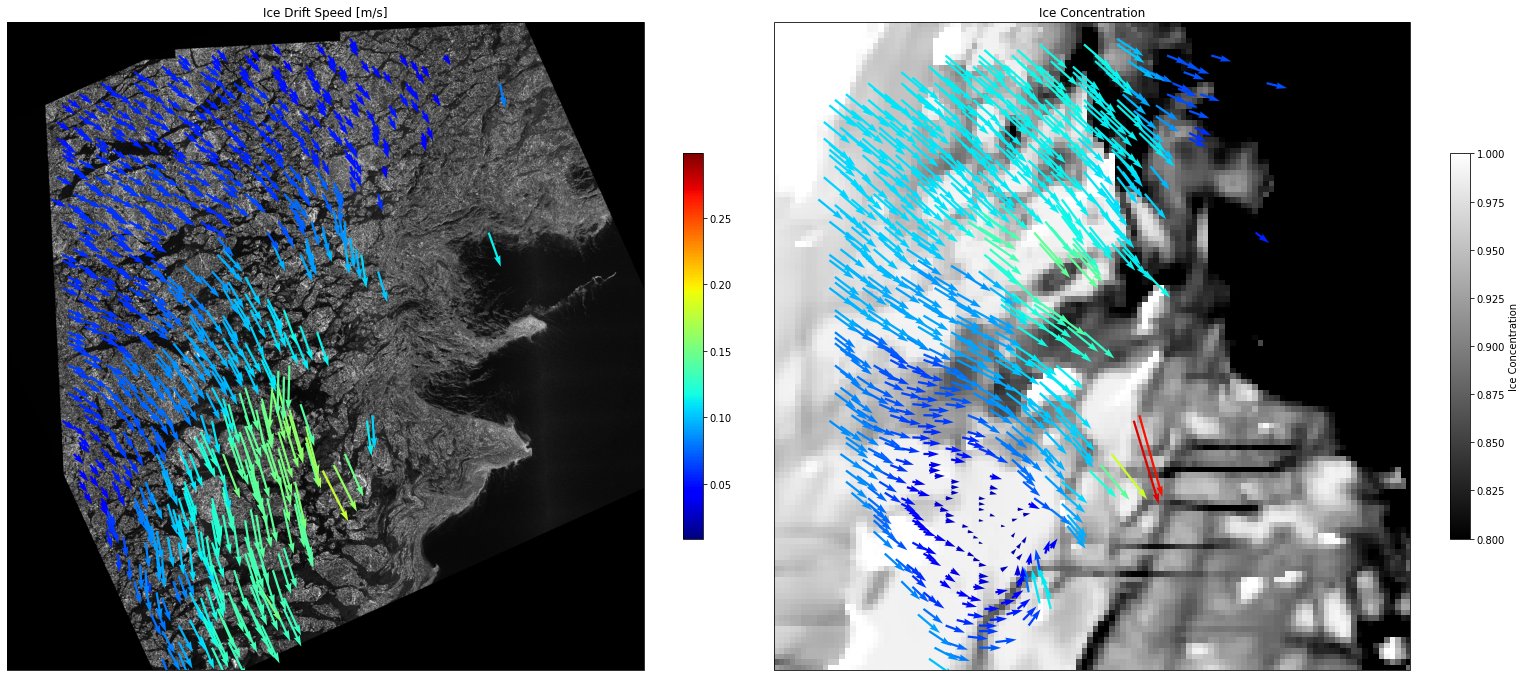

In [421]:
from matplotlib.colors import Normalize
dayssec = 24*60*60 # !!!! provide real time difference time_period[-1]-time_period[0]

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 

# compute model ice drift speed [m/s]
delta_t = dayssec #in seconds
u_model = dx_mod / delta_t
v_model = dy_mod / delta_t
speed_model = np.sqrt((v_model**2+u_model**2)) 

# Combined data range
all_speeds = np.concatenate([speed[gpi], speed_model[gpi]])
vmin, vmax = np.min(all_speeds), np.max(all_speeds)

# Use this range to normalize both datasets
norm = Normalize(vmin=vmin, vmax=vmax)



gpi = (hpm > 7) *(siconc_subset > 0.9)
#gpi = (hpm < 7) *(siconc_subset < 0.95)
num_true_values = np.sum(gpi.data)
print(f"Number of True values in gpi: {num_true_values}")

# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(22,11), subplot_kw={'projection': crs})

# Plot the image on the first subplot
ax1.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv1 = ax1.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6], speed[gpi][::6], scale=2, cmap='jet', width=0.0035, norm=norm)
ax1.set_title('Ice Drift Speed [m/s]')
ax1.add_feature(land_50m, edgecolor='black')
ax1.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax1.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.colorbar(quiv1, ax=ax1, orientation='vertical', shrink=0.5)
#plt.quiverkey(quiv1, 110000, -770000, 0.05, '0.05 m/s', coordinates='data', ax=ax1)

# Plot the concentration on the second jet
conc_img = ax2.imshow(siconc_subset, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper', cmap='gray', alpha=1, vmin=0.8, vmax=1)
quiv2 = ax2.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u_model[gpi][::6], v_model[gpi][::6], speed_model[gpi][::6], scale=2, cmap='jet', width=0.0035, norm=norm)
ax2.set_title('Ice Concentration')
ax2.add_feature(land_50m, edgecolor='black')
ax2.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax2.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.colorbar(conc_img, ax=ax2, label='Ice Concentration', shrink=0.5)



plt.tight_layout()
plt.show()


Number of True values in gpi: 4795


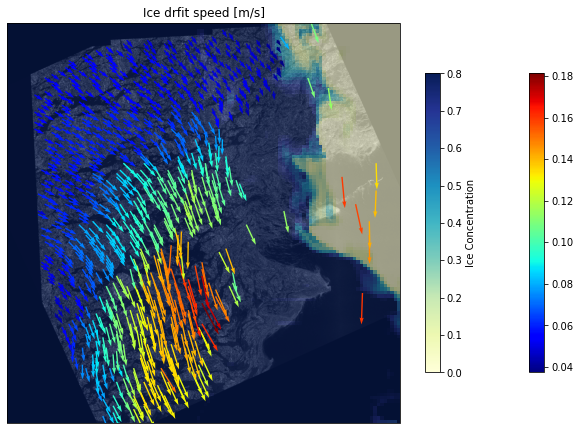

In [355]:
from matplotlib.patches import Rectangle

dayssec = 24*60*60 # !!!! provide real time difference time_period[-1]-time_period[0]

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 

# plot valid vectors in Polar stereographic projection
gpi = (hpm > 7)#*(siconc_subset > 0.1)
num_true_values = np.sum(gpi.data)
print(f"Number of True values in gpi: {num_true_values}")
# X/Y grids in polar stereographic projection covering image_1
#x1pm, y1pm = dom_pm.get_geolocation_grids(dst_srs=srs)
#x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)


# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)


plt.figure(figsize=(11,11))
ax = plt.axes(projection=crs)


# Plotting model concentration
conc_img = ax.imshow(siconc_subset, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper', cmap='YlGnBu', alpha=1, vmin=0, vmax=0.8)

ax.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper', alpha=0.4) 

# Overlay a semi-transparent gray layer
#gray_value = 0.2 # Midway between 0 (black) and 1 (white)
#rect = Rectangle((x1pm.min(), y1pm.min()), x1pm.max() - x1pm.min(), y1pm.max() - y1pm.min(), facecolor=str(gray_value), alpha=0.5)
#ax.add_patch(rect)


#plot every n_th vector
quiv=ax.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=2, cmap='jet',width=0.0035) #, 
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

# Colorbar for the concentration
plt.colorbar(conc_img, ax=ax, label='Ice Concentration', shrink=0.5)

#ax.set_xlim([x1pm.min(), x1pm.max()])
#ax.set_ylim([y1pm.min(), y1pm.max()])


ax.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.show()

Number of True values in gpi: 3673


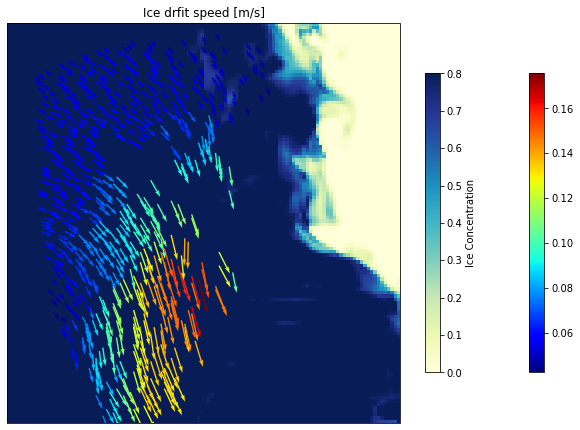

In [326]:
from matplotlib.patches import Rectangle

dayssec = 24*60*60 # !!!! provide real time difference time_period[-1]-time_period[0]

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 

# plot valid vectors in Polar stereographic projection
gpi = (hpm > 7)*(siconc_subset > 0.92)
num_true_values = np.sum(gpi.data)
print(f"Number of True values in gpi: {num_true_values}")
# X/Y grids in polar stereographic projection covering image_1
#x1pm, y1pm = dom_pm.get_geolocation_grids(dst_srs=srs)
#x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)


# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)


plt.figure(figsize=(11,11))
ax = plt.axes(projection=crs)

# Plotting model concentration
conc_img = ax.imshow(siconc_subset, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper', cmap='YlGnBu', alpha=1, vmin=0,  vmax=0.8)


#plot every n_th vector
quiv=ax.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=2, cmap='jet',width=0.0035) #, 
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

# Colorbar for the concentration
plt.colorbar(conc_img, ax=ax, label='Ice Concentration', shrink=0.5)

#ax.set_xlim([x1pm.min(), x1pm.max()])
#ax.set_ylim([y1pm.min(), y1pm.max()])


ax.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.show()

### Comparison of model and algorithm drift

In [ ]:
import csv

In [ ]:
cum_drift_path = r'/home/jovyan/data/model_data_process_output/for_comparison_lambert/total_model_displacement_20221119T07-20221120T09.csv'

In [ ]:
with open(cum_drift_path) as csvfile:
    csvreader = csv.reader(csvfile)
    # check if the file has a header row
    has_header = csv.Sniffer().has_header(csvfile.read(1024))
    csvfile.seek(0)  # reset file pointer
    #skip header row if it exists
    if has_header:
        next(csvreader)
    displacements = np.array([row for row in csvreader]).astype(float)

In [ ]:
lon_mod, lat_mod = displacements[:, [0]] , displacements[:, [1]] 
dx_mod, dy_mod = displacements[:, [2]] , displacements[:, [3]] 

In [ ]:
lon_mod.shape, lat_mod.shape,dx_mod.shape, dy_mod.shape 

In [ ]:
dx_mod = dx_mod.reshape(154, 160)
dy_mod = dy_mod.reshape(154, 160) 

In [ ]:
ref_displacement = np.sqrt((upm**2+vpm**2))
model_displacement =  np.sqrt((dx_mod**2+dy_mod**2))

In [ ]:
rmse = np.sqrt(np.nanmean((ref_displacement - model_displacement)**2))
rmse

In [ ]:
# Calculate RMSE
rmse = np.sqrt(np.nanmean((ref_displacement - model_displacement) ** 2))

# Calculate average of reference data (arr1)
average_ref_displacement = np.nanmean(ref_displacement)

# Calculate Relative RMSE in percentage
relative_rmse = (rmse / average_ref_displacement) * 100

print(f"Relative RMSE: {relative_rmse:.2f}%")

In [ ]:
# Root Mean Square Error
rmse = np.sqrt(np.nanmean((upm - dx_mod)**2))

# Absolute Error 
abs_error_dx = (upm - dx_mod)
abs_error_dy = (vpm - dy_mod)

# Relative Error (check for zeroes)
relative_error_dx = (upm - dx_mod)/upm
relative_error_dy = (vpm - dy_mod)/upm

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(abs_error_dx, abs_error_dy, alpha=0.5)
plt.xlabel('Absolute Error in X displacement')
plt.ylabel('Absolute Error in Y displacement')
plt.title('Scatter plot of Absolute Errors in X and Y displacements')
plt.axhline(0, color='black',linewidth=0.5)
plt.axvline(0, color='black',linewidth=0.5)
plt.grid(True, which="both", ls="--", c='0.7')
plt.show()

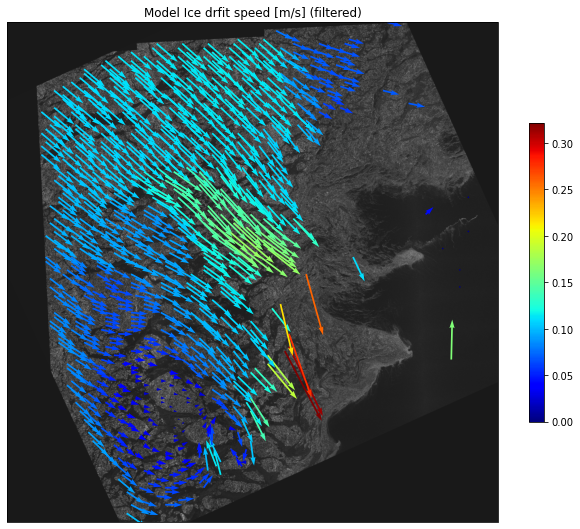

In [356]:
dayssec = 24*60*60

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = dx_mod / delta_t
v = dy_mod / delta_t
speed = np.sqrt((v**2+u**2)) 

# plot valid vectors in Polar stereographic projection
gpi = (hpm > 7) 
# X/Y grids in polar stereographic projection covering image_1
#x1pm, y1pm = dom_pm.get_geolocation_grids(dst_srs=srs)
#x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)


# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)


plt.figure(figsize=(11,11))
ax = plt.axes(projection=crs)


ax.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper') 
# Overlay a semi-transparent gray layer
gray_value = 0.2 # Midway between 0 (black) and 1 (white)
rect = Rectangle((x1pm.min(), y1pm.min()), x1pm.max() - x1pm.min(), y1pm.max() - y1pm.min(), facecolor=str(gray_value), alpha=0.5)
ax.add_patch(rect)
#plot every n_th vector
quiv=ax.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=2, cmap='jet',width=0.0035) #, 
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Model Ice drfit speed [m/s] (filtered)')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

#ax.set_xlim([x1pm.min(), x1pm.max()])
#ax.set_ylim([y1pm.min(), y1pm.max()])


ax.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.show()

In [ ]:
delta_t = dayssec #in seconds
u = dx_mod / delta_t
v = dy_mod / delta_t
speed_model = np.sqrt((v**2+u**2)) 

# compute ice drift ERROR speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed_ref = np.sqrt((v**2+u**2)) 

In [ ]:
plt.figure(figsize=(8,6))


# Plotting Model Speed
plt.hist(speed_model[gpi], bins=50, color='red', alpha=0.5, label='Model Speeds')

# Plotting Reference Speed
plt.hist(speed_ref[gpi], bins=50, color='blue', alpha=0.5, label='Reference Speeds')

plt.xlabel('Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Ice Drift Speeds (filtered)')
plt.legend()
plt.show()

# Print statistics for reference speeds
percentile_95_ref = np.percentile(speed_ref[gpi], 95)
mean_speed_ref = np.nanmean(speed_ref[gpi])
min_speed_ref = np.nanmin(speed_ref[gpi])
max_speed_ref = np.nanmax(speed_ref[gpi])

print(f"Reference Speeds:")
print(f"Mean speed: {mean_speed_ref:.4f} m/s")
print(f"Min speed: {min_speed_ref:.4f} m/s")
print(f"Max speed: {max_speed_ref:.4f} m/s")
print(f"95th percentile speed: {percentile_95_ref:.4f} m/s")

# Print statistics for model speeds
percentile_95_model = np.percentile(speed_model[gpi], 95)
mean_speed_model = np.nanmean(speed_model[gpi])
min_speed_model = np.nanmin(speed_model[gpi])
max_speed_model = np.nanmax(speed_model[gpi])

print("\nModel Speeds:")
print(f"Mean speed: {mean_speed_model:.4f} m/s")
print(f"Min speed: {min_speed_model:.4f} m/s")
print(f"Max speed: {max_speed_model:.4f} m/s")
print(f"95th percentile speed: {percentile_95_model:.4f} m/s")


In [ ]:
#for all values
plt.figure(figsize=(8,6))


# Plotting Model Speed
plt.hist(speed_model.flatten(), bins=50, color='red', alpha=0.5, label='Model Speeds')

# Plotting Reference Speed
plt.hist(speed_ref.flatten(), bins=50, color='blue', alpha=0.5, label='Reference Speeds')

plt.xlabel('Speed (m/s)')
plt.ylabel('Frequency')
plt.title('Distribution of Ice Drift Speeds for all values')
plt.legend()
plt.show()

# Print statistics for reference speeds
percentile_95_ref = np.percentile(speed_ref[gpi], 95)
mean_speed_ref = np.nanmean(speed_ref[gpi])
min_speed_ref = np.nanmin(speed_ref[gpi])
max_speed_ref = np.nanmax(speed_ref[gpi])

print(f"Reference Speeds:")
print(f"Mean speed: {mean_speed_ref:.4f} m/s")
print(f"Min speed: {min_speed_ref:.4f} m/s")
print(f"Max speed: {max_speed_ref:.4f} m/s")
print(f"95th percentile speed: {percentile_95_ref:.4f} m/s")

# Print statistics for model speeds
percentile_95_model = np.percentile(speed_model[gpi], 95)
mean_speed_model = np.nanmean(speed_model[gpi])
min_speed_model = np.nanmin(speed_model[gpi])
max_speed_model = np.nanmax(speed_model[gpi])

print("\nModel Speeds:")
print(f"Mean speed: {mean_speed_model:.4f} m/s")
print(f"Min speed: {min_speed_model:.4f} m/s")
print(f"Max speed: {max_speed_model:.4f} m/s")
print(f"95th percentile speed: {percentile_95_model:.4f} m/s")


In [ ]:
from matplotlib.patches import Rectangle

dayssec = 24*60*60

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = abs_error_dx / delta_t
v = abs_error_dy / delta_t
speed = np.sqrt((v**2+u**2)) 


# plot valid vectors in Polar stereographic projection
gpi = (hpm > 7) 
# X/Y grids in polar stereographic projection covering image_1
#x1pm, y1pm = dom_pm.get_geolocation_grids(dst_srs=srs)
#x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)


# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)


plt.figure(figsize=(11,11))
ax = plt.axes(projection=crs)


ax.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper') 
# Overlay a semi-transparent gray layer
gray_value = 0.2 # Midway between 0 (black) and 1 (white)
rect = Rectangle((x1pm.min(), y1pm.min()), x1pm.max() - x1pm.min(), y1pm.max() - y1pm.min(), facecolor=str(gray_value), alpha=0.5)
ax.add_patch(rect)
#plot every n_th vector
quiv=ax.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=1.5, cmap='jet',width=0.0035) #, 
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

#ax.set_xlim([x1pm.min(), x1pm.max()])
#ax.set_ylim([y1pm.min(), y1pm.max()])


ax.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.show()

In [ ]:
from matplotlib.patches import Rectangle

dayssec = 24*60*60

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = abs_error_dx / delta_t
v = abs_error_dy / delta_t 
speed = np.sqrt((v**2+u**2)) 
speed = np.copy(speed)
speed[speed > 0.1356] = np.nan

#(0.1356 is 95 percentile) 


# plot valid vectors in Polar stereographic projection
gpi = (hpm > 7) 
# X/Y grids in polar stereographic projection covering image_1
#x1pm, y1pm = dom_pm.get_geolocation_grids(dst_srs=srs)
#x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)


# spacial reference for plotting
crs = ccrs.LambertConformal(central_longitude=-25,
    central_latitude=77.5,
    false_easting=0.0,
    false_northing=0.0,
    secant_latitudes=None,
    standard_parallels=(77.5, 77.5),
    globe=None)


plt.figure(figsize=(11,11))
ax = plt.axes(projection=crs)


ax.imshow(n1[1], cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper') 
# Overlay a semi-transparent gray layer
gray_value = 0.2 # Midway between 0 (black) and 1 (white)
rect = Rectangle((x1pm.min(), y1pm.min()), x1pm.max() - x1pm.min(), y1pm.max() - y1pm.min(), facecolor=str(gray_value), alpha=0.5)
ax.add_patch(rect)
#plot every n_th vector
quiv=ax.quiver(x1pm[gpi][::6], y1pm[gpi][::6], u[gpi][::6], v[gpi][::6],speed[gpi][::6], scale=1.5, cmap='jet',width=0.0035) #, 
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

#ax.set_xlim([x1pm.min(), x1pm.max()])
#ax.set_ylim([y1pm.min(), y1pm.max()])


ax.set_xlim([x1pm.min()+40000, x1pm.max()-70000])
ax.set_ylim([y1pm.min()+30000, y1pm.max()-60000])
plt.show()

In [ ]:
displacements = displacements[~np.any(np.isnan(displacements), axis=1), :]
displacements = displacements[~np.any(np.isinf(displacements), axis=1), :]